In [1]:
import os
import random

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

from ImageAestheticsGANs.AADB.AADB import AADB, AADB_binaries
from tqdm import tqdm
from ImageAestheticsGANs.utils.utils import *
from ImageAestheticsGANs.models.ResNet18 import RegressionNetwork
from ImageAestheticsGANs.loss_functions.rank_loss import RegRankLoss
import torch.nn as nn

### Variables

In [2]:
batch_size = 64
epochs = 200
load = True
ckpt = 'F:\Projects\Disertatie\RESULTS\ResNet_classificaiton_11_attributes\AADB_epoch_199_loss_0.7456_.pt'
lr=0.001
beta = 0.5  # Adam

In [3]:
data_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'

## AADB

In [4]:
aadb = AADB_binaries(data_path)
aadb_test = AADB_binaries(data_path, test=True)
n_classes = aadb.get_num_classes()

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


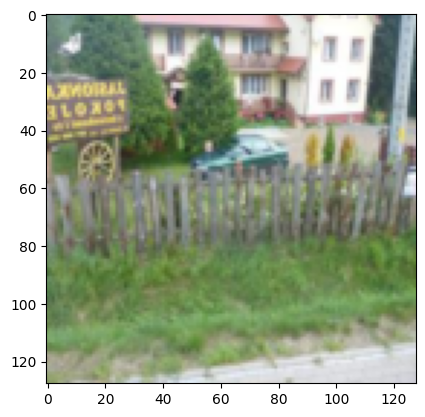

8958

In [5]:
show_example(*aadb[0])
len(aadb)

tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0])


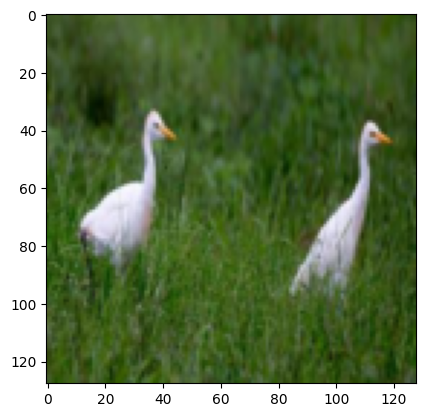

1000

In [6]:
show_example(*aadb_test[0])
len(aadb_test)

## Dataloaders

In [7]:
val_size = 500
train_size = len(aadb) - val_size

train_ds, val_ds = random_split(aadb, [train_size, val_size])
len(train_ds), len(val_ds)

(8458, 500)

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

In [9]:
print(len(train_dl))
print(len(valid_dl))

132
8


In [10]:
for image, _ in train_dl:
    print(image.shape)
    break

torch.Size([64, 3, 128, 128])


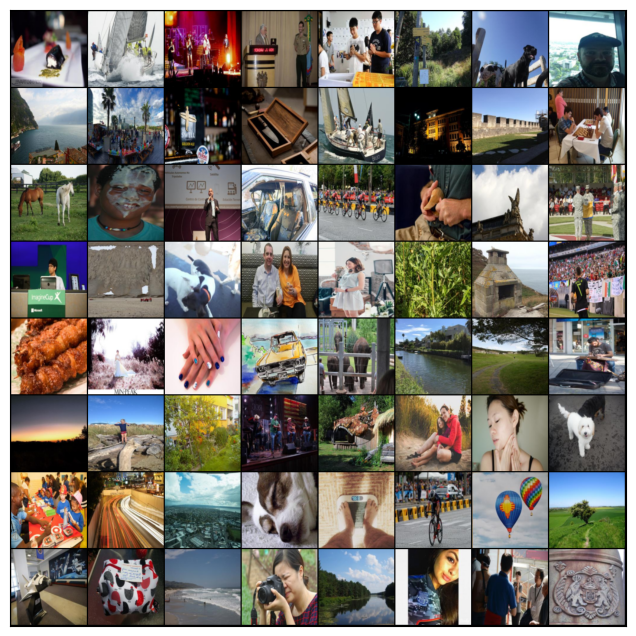

In [11]:
show_batch(train_dl)

## GPU

In [12]:
def get_default_device():
    '''Pick GPU if available'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True).to(torch.float32)

In [13]:
class DeviceDataLoader():
    def __init__(self, dl ,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Criterion

In [23]:
# criterion = nn.CrossEntropyLoss()

In [24]:
criterion = nn.BCEWithLogitsLoss()

In [25]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#
#     def forward(self, inputs, targets):
#         BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
#         return F_loss.mean()
#
# criterion = FocalLoss()

In [26]:
# criterion = nn.MultiLabelSoftMarginLoss

In [27]:
# def criterion(input, target, esp=1e-19):
#     loss = - torch.mean(target * torch.log(input.clamp_min(esp))) - torch.mean(
#         (1 - target) * torch.log((1 - input).clamp_min(esp)))
#     return loss

In [28]:
print(len(train_dl))
print(len(valid_dl))

132
8


In [13]:
model = RegressionNetwork(backbone='resnet18', num_attributes=n_classes, pretrained=True)
model = model.to('cuda')

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train

In [48]:
# opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta, 0.999))
opt = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

if load:
    print("Loading checkpoint...")

    checkpoint = torch.load(ckpt)
    last_epoch = checkpoint['epoch']

    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

    loss = train_losses[-1]

    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['optimizer'])
    model.eval()

else:
    last_epoch = 0

    train_losses = []
    val_losses = []

for epoch in range(last_epoch, epochs):

    # Training Phase
    model.train()

    pbar = tqdm(enumerate(train_dl), total=len(train_dl))
    for batch, (images, labels) in pbar:

        opt.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # predicted = outputs.detach() > 0.5

        # correct = (predicted == labels.type(torch.uint8))

        # accuracy = correct.sum().item() / (len(correct) * n_classes)

        opt.step()

        # pbar.set_description("Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}".format(
        #     epoch, float(loss), float(accuracy)))
        pbar.set_description("Epoch {}, Loss: {:.4f}".format(
            epoch, float(loss)))
    train_losses.append(loss)


    # Evaluation Phase
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(enumerate(valid_dl), total=len(valid_dl))
    for batch, (images, labels) in pbar:
        with torch.no_grad():
            outputs = model(images)

            predicted = outputs > 0.5

            correct += (predicted == labels.type(torch.uint8)).sum().item()
            total += len(labels) * n_classes

    accuracy = correct / total
    val_losses.append(accuracy)
    print('Accuracy of all test images: %.3f' % (accuracy * 100))
    filename = "{}_epoch_{}_loss_{:.4f}_.pt".format('AADB', epoch, accuracy)
    torch.save({'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
             },  os.path.join('F:\Projects\Disertatie\ImageAestheticsGANs\classifier_ckpt_2', filename))
    load = False

Loading checkpoint...


100%|██████████| 8/8 [00:01<00:00,  7.10it/s]


Accuracy of all test images: 69.750


100%|██████████| 8/8 [00:01<00:00,  7.27it/s]


Accuracy of all test images: 69.875


100%|██████████| 8/8 [00:01<00:00,  7.09it/s]


Accuracy of all test images: 69.525


100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


Accuracy of all test images: 69.375


100%|██████████| 8/8 [00:01<00:00,  7.27it/s]


Accuracy of all test images: 69.200


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


Accuracy of all test images: 69.850


100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


Accuracy of all test images: 69.275


100%|██████████| 8/8 [00:01<00:00,  7.28it/s]


Accuracy of all test images: 69.375


100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


Accuracy of all test images: 69.400


100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


Accuracy of all test images: 69.575


100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


Accuracy of all test images: 69.475


100%|██████████| 8/8 [00:01<00:00,  7.18it/s]


Accuracy of all test images: 69.625


100%|██████████| 8/8 [00:01<00:00,  7.11it/s]


Accuracy of all test images: 69.725


Epoch 212, Loss: 0.6261:  20%|█▉        | 26/132 [00:06<00:25,  4.15it/s]


KeyboardInterrupt: 

## Evaluate

In [17]:
ckpt = 'F:\Projects\Disertatie\RESULTS\ResNet_classificaiton_11_attributes\AADB_epoch_199_loss_0.7456_.pt'

In [18]:
model = RegressionNetwork(backbone='resnet18', num_attributes=n_classes, pretrained=True)
model = model.to('cuda')
model.load_state_dict(torch.load(ckpt)['model'])
model.eval()

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [19]:
test_dl = DataLoader(aadb_test, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for batch, (images, labels) in tqdm(enumerate(test_dl), total=len(test_dl)):

        outputs = model(images)

        predicted = outputs > 0.5

        correct += (predicted == labels.type(torch.uint8)).sum().item()
        total += len(labels) * n_classes

    accuracy = correct / total
    print('Accuracy of all test images: %.3f' % (accuracy * 100))

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

Accuracy of all test images: 71.391


In [48]:
def plot_loss(train_losses):
    train_losses_list = [i.item() for i in train_losses]
    # val_losses_list = [i for i in val_losses]
    plt.plot(train_losses_list, '-bx')
    # plt.plot(val_losses_list, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training'])
    plt.title('Loss vs No. of epochs')

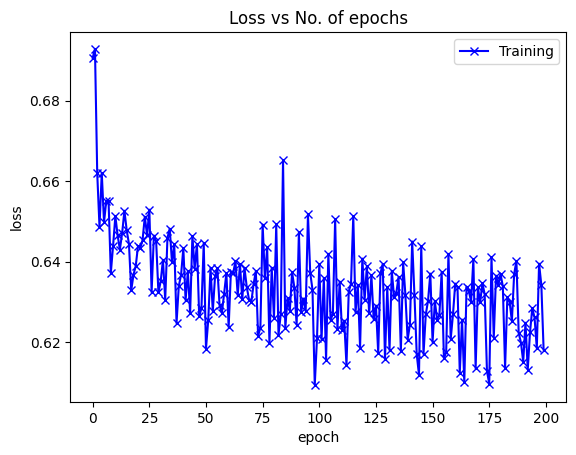

In [49]:
checkpoint = torch.load(ckpt)
train_losses = torch.load(ckpt)['train_losses']
# val_losses = torch.load(ckpt)['val_losses']
plot_loss(train_losses)

## Application

In [45]:
i = random.randint(0, len(aadb_test))
x, y = aadb[i]
x_tensor = x.to("cuda").unsqueeze(0)
y_pred = model(x_tensor)    #.cpu().detach().numpy()
print(y_pred)
predicted = y_pred > 0.5
# print(predicted)
predicted = predicted.cpu().detach().numpy()
print(predicted)
y = y.numpy()
print(y)

tensor([1.2486e-04, 5.2186e-01, 9.3715e-01, 9.1580e-05, 1.5683e-03, 9.9997e-01,
        9.3347e-04, 7.7100e-06, 9.9833e-01, 5.7177e-06, 9.0851e-01],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
[False  True  True False False  True False False  True False  True]
[0 0 1 1 0 1 1 1 1 0 0]


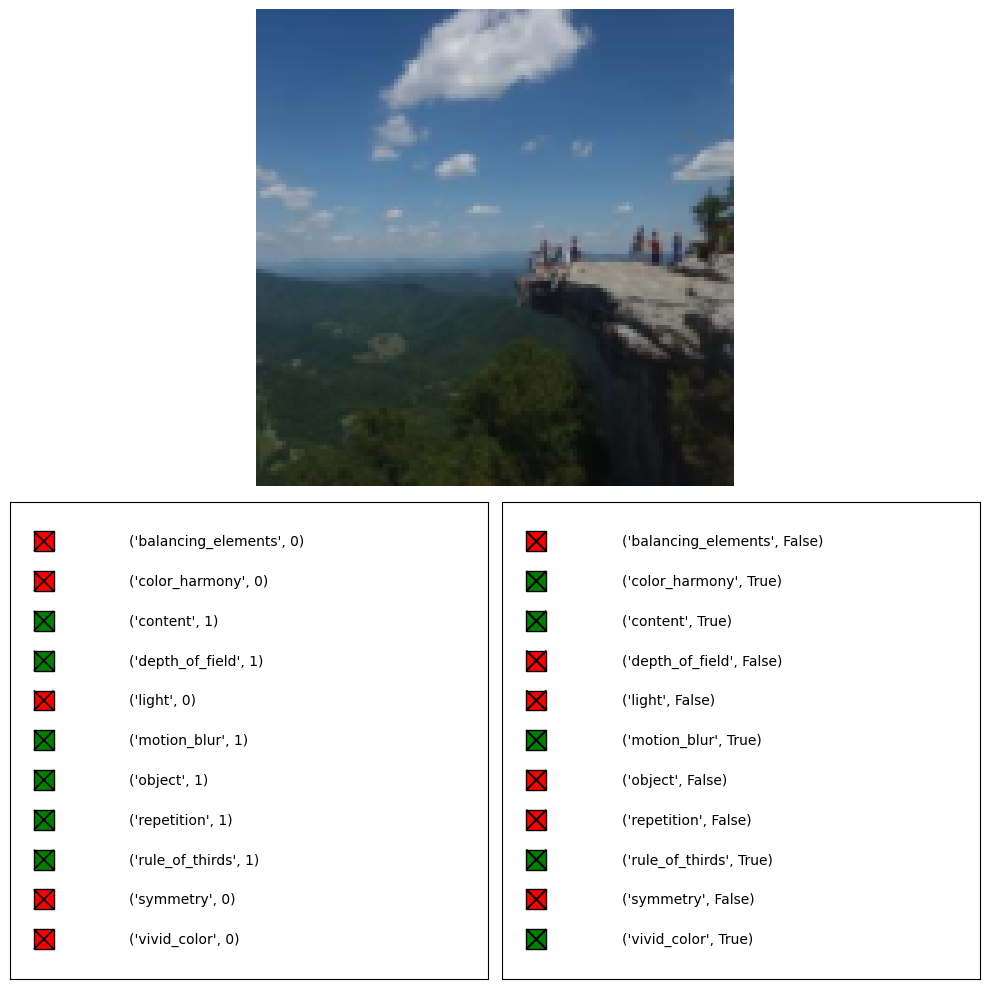

In [46]:
display_aesthetics(x, y, predicted, interval=[0, 0], score=False)